## Example script

In this notebook, we apply the Sparse Structure Discovery (SSD) framework on an example dataset. 

The method takes as input 
1. $F$: an $E \times L$ effects matrix, where $E$ is the number of phenotypes and $L$ is the number of perturbed loci. 
2. The regularization parameters $\lambda_W$ and $\lambda_M$: The rotation tests and solution space plots shown below can be used to guide the choice of these parameters. 
3. $K_{\max}$: the maximum number of core processes. Note that the $K$ ($\le K_{\max}$) selected by SSD will depend on $\lambda_W$ and $\lambda_M$. 

and yields
1. $W$: an $E \times K$ matrix representing the process-phenotype map.
2. $M$: a $K \times L$ matrix representing the loci-process map.
3. $b$: a $1 \times L$ vector representing the locus-specific effects of loci on all the phenotypes. b = 0 if subtract_means = True (see below). 

In [1]:
#Load libraries

import numpy as np
import matplotlib.pyplot as plt
import os 

import sys
sys.path.insert(0, 'utils/')

from factorizer import *
import ssd
import pandas as pd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
#We will use the genotoxin dataset as the example.  
od = pd.read_csv("data/genotoxic_input.tsv", sep = '\t') 
od = od.set_index("Treatment")
F = od.values #get matrix of additive effects

### Initialization

In [5]:
fct = factorizer() #initialize factorizer object. 

#If subtract_means = True, the mean of each column of F is subtracted from each element of that column. 
#The resulting vector b is typically close to zero after applying the decomposition.
fct.subtract_means = False 

#initialize with F. The raw F is stored as fct.FTrue and the normalized F is stored as fct.FF
fct.init_with_F(F) 

fct.env_names = list(od.index) #give labels to the phenotypes
fct.loci_names = list(od.columns) #give labels to the loci

#use the function "print_factorizer_help()" for more details

### Pick parameter ranges 

In [13]:
#Pick the range of lamb_W and lamb_M to run the method. 
#These values often work well across datasets as F is normalized

lambW_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),20))
lambM_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),20))

# Use SVD to pick K_max as the number of SVD components that explain thresh = 95% of the variance in F. 

def pick_k(F, thresh = .95, printout = True):
    u,s1,vh = np.linalg.svd(F)
    Ks = []
    err_SVDs =[]
    for K in range(1,F.shape[0],1):
        u_K = u[:,:K]
        s_K = s1[:K]
        vh_K = vh[:K]

        err_SVD =  np.mean((F - np.matmul(u_K,s_K[:,None]*vh_K))**2)
        if printout: print("%02d   %.3f" %(K,err_SVD))

        Ks += [K]
        err_SVDs += [err_SVD]
        
    for n, err in enumerate(err_SVDs):
        if err< 1-thresh:
            return Ks[n]
        
Kmax = pick_k(fct.FF, printout = False)
print(f"will run method with K_max = {Kmax}")

will run method with K_max = 20


### Factorize 

In [18]:
#Find the SVD solution
fct.svd(K)

#Factorize for the full grid of parameter values (can take ~30 minutes)
fct.factorize_regularized_range(K, lambW_range, lambM_range, verbose = True) 

K    lamb1    lamb2   error_ours  error_svd   Keff   av.mod./loci   av.mod./env   loci dropped    grassmann to svd
20   0.0001    0.0010     0.038       0.038     20      19.921          16.677           0             0.041
20   0.0001    0.0015     0.038       0.038     20      19.875          16.774           0             0.043
20   0.0001    0.0022     0.038       0.038     20      19.839          16.806           0             0.047
20   0.0001    0.0032     0.038       0.038     20      19.737          16.968           0             0.056
20   0.0001    0.0047     0.038       0.038     20      19.638          17.129           0             0.073
20   0.0001    0.0069     0.038       0.038     20      19.434          17.355           0             0.101
20   0.0001    0.0101     0.038       0.038     20      19.125          17.645           0             0.150
20   0.0001    0.0148     0.039       0.038     20      18.678          18.226           0             0.223
20   0.0001  

20   0.0002    0.3217     0.150       0.038     16      5.780          15.065           0             2.568
20   0.0002    0.4727     0.200       0.038     14      3.868          13.323           0             2.393
20   0.0002    0.6946     0.271       0.038     12      2.359          11.645           3             2.362
20   0.0002    1.0208     0.378       0.038      9      1.695          8.742          38             2.168
20   0.0002    1.5000     0.525       0.038      6      1.218          5.677         148             2.041
20   0.0003    0.0010     0.038       0.038     20      19.947          14.000           0             0.105
20   0.0003    0.0015     0.038       0.038     20      19.911          14.000           0             0.106
20   0.0003    0.0022     0.038       0.038     20      19.868          14.161           0             0.107
20   0.0003    0.0032     0.038       0.038     20      19.789          14.129           0             0.110
20   0.0003    0.0047     

20   0.0005    0.0690     0.048       0.038     20      14.961          14.968           0             1.029
20   0.0005    0.1014     0.061       0.038     20      12.760          15.419           0             1.760
20   0.0005    0.1490     0.081       0.038     20      10.207          15.484           0             2.392
20   0.0005    0.2189     0.114       0.038     19      7.740          15.516           0             2.993
20   0.0005    0.3217     0.156       0.038     15      5.536          12.903           0             2.287
20   0.0005    0.4727     0.203       0.038     13      3.849          11.290           0             2.054
20   0.0005    0.6946     0.278       0.038     12      2.344          10.839           5             2.418
20   0.0005    1.0208     0.386       0.038      9      1.659          7.935          43             2.236
20   0.0005    1.5000     0.530       0.038      6      1.209          5.194         151             2.077
20   0.0007    0.0010     0

20   0.0014    0.0148     0.045       0.038     20      19.155          6.871           0             0.691
20   0.0014    0.0217     0.046       0.038     20      18.704          6.871           0             0.722
20   0.0014    0.0319     0.047       0.038     20      18.214          7.226           0             0.797
20   0.0014    0.0469     0.049       0.038     20      17.174          7.548           0             0.943
20   0.0014    0.0690     0.054       0.038     20      15.536          7.806           0             1.217
20   0.0014    0.1014     0.068       0.038     20      13.105          8.968           0             1.805
20   0.0014    0.1490     0.091       0.038     20      10.352          9.677           0             2.521
20   0.0014    0.2189     0.126       0.038     17      7.622          8.581           0             2.452
20   0.0014    0.3217     0.175       0.038     13      5.211          8.129           0             1.751
20   0.0014    0.4727     0.22

20   0.0038    0.0047     0.058       0.038     20      19.766          2.903           0             1.061
20   0.0038    0.0069     0.058       0.038     20      19.641          2.710           0             1.052
20   0.0038    0.0101     0.058       0.038     20      19.428          2.806           0             1.044
20   0.0038    0.0148     0.058       0.038     20      19.234          2.839           0             1.032
20   0.0038    0.0217     0.059       0.038     20      18.770          2.645           0             1.108
20   0.0038    0.0319     0.060       0.038     20      18.046          2.839           0             0.914
20   0.0038    0.0469     0.067       0.038     20      17.122          2.968           0             1.599
20   0.0038    0.0690     0.071       0.038     20      15.668          2.710           0             1.652
20   0.0038    0.1014     0.092       0.038     18      12.914          2.613           0             1.384
20   0.0038    0.1490     0.

20   0.0100    0.0015     0.099       0.038     20      19.908          1.226           0             1.677
20   0.0100    0.0022     0.101       0.038     20      19.862          1.194           0             1.708
20   0.0100    0.0032     0.112       0.038     20      19.826          1.323           0             1.831
20   0.0100    0.0047     0.110       0.038     19      18.635          1.286           0             1.048
20   0.0100    0.0069     0.111       0.038     19      18.487          1.379           0             1.031
20   0.0100    0.0101     0.119       0.038     19      18.385          1.310           0             1.318
20   0.0100    0.0148     0.118       0.038     18      17.237          1.241           0             0.888
20   0.0100    0.0217     0.119       0.038     18      16.812          1.345           0             0.935
20   0.0100    0.0319     0.120       0.038     18      16.188          1.310           0             1.027
20   0.0100    0.0469     0.

In [20]:
#View all the computed parameters
fct.computed_params();

Factorization complete for the following parameter choices:
('svd', 20, None, (0, 0))
('reg', 20, (0.0001, 0.001), (0, 0))
('reg', 20, (0.0001, 0.0015), (0, 0))
('reg', 20, (0.0001, 0.0022), (0, 0))
('reg', 20, (0.0001, 0.0032), (0, 0))
('reg', 20, (0.0001, 0.0047), (0, 0))
('reg', 20, (0.0001, 0.0069), (0, 0))
('reg', 20, (0.0001, 0.0101), (0, 0))
('reg', 20, (0.0001, 0.0148), (0, 0))
('reg', 20, (0.0001, 0.0217), (0, 0))
('reg', 20, (0.0001, 0.0319), (0, 0))
('reg', 20, (0.0001, 0.0469), (0, 0))
('reg', 20, (0.0001, 0.069), (0, 0))
('reg', 20, (0.0001, 0.1014), (0, 0))
('reg', 20, (0.0001, 0.149), (0, 0))
('reg', 20, (0.0001, 0.2189), (0, 0))
('reg', 20, (0.0001, 0.3217), (0, 0))
('reg', 20, (0.0001, 0.4727), (0, 0))
('reg', 20, (0.0001, 0.6946), (0, 0))
('reg', 20, (0.0001, 1.0208), (0, 0))
('reg', 20, (0.0001, 1.5), (0, 0))
('reg', 20, (0.0002, 0.001), (0, 0))
('reg', 20, (0.0002, 0.0015), (0, 0))
('reg', 20, (0.0002, 0.0022), (0, 0))
('reg', 20, (0.0002, 0.0032), (0, 0))
('reg', 2

### Solution space 

('reg', 20, (0.0009, 1.0208), (0, 0)) 1.6589147286821706 6.645161290322581 8 0.39629424333804175
('reg', 20, (0.0062, 0.4727), (0, 0)) 2.9735099337748343 2.3666666666666667 10 0.31344658382539875


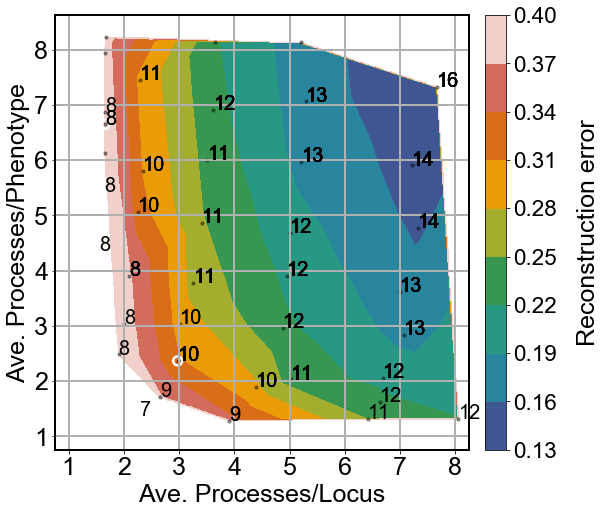

In [22]:
#Plot solution space

#apl is the average processes per locus
#app is the average processes per phenotype

scatter = True
ve = .25 #axes extension

#specify max and min apl and app respectively to determine the range of solutions examined
minx = 1-ve
maxx = 8+ve
miny = 1-ve
maxy = 8+ve

#colorbar range
vmax = 0.40
vmin = 0.13

#specify pairs of (apl,app) whose K should be plotted on the solution space
kpts = []
for i in np.arange(2.0,8,.5):
    for j in np.arange(1.5,8,.5):
        if i==2:
            if j in [1.5,2,3,6]:
                continue
        if j<2 and i==3: continue
        kpts.append((i,j))

cps = [(2,6.7),(3.2,2.5)] #specify pairs of (apl,app) which should be highlighted on the solution space
kpts += cps

#plot
plot_solution_space(fct, K, lambW_range, lambM_range,  minx, maxx, miny, maxy, vmax, vmin, fs = 25,scatter=True, scatter_restricted=False, restrict_in_range = True, k_labeled_points = kpts, circled_points = cps)

### Rotation tests 

In [24]:
#Initialize factorizers for rotation tests
E, L = fct.FF.shape #get shape of F
ofseed = 1
foseed = 1

#OF -- phenotype rotation test
fct_of = factorizer()
fct_of.subtract_means = False
fct_of.rescale = False #for rotation test, do not rescale
FF = deepcopy(fct.FF) # this is centered, normalized F
O = ortho_group.rvs(dim=E, random_state = ofseed)
FF_rot = O@FF 
fct_of.init_with_F(FF_rot)


#FO -- loci rotation test
fct_fo = factorizer()
fct_fo.subtract_means = False
fct_fo.rescale = False
FF = deepcopy(fct.FF) # this is centered, normalized WM + C after noise added
O = ortho_group.rvs(dim=L, random_state = foseed)
FF_rot = FF @ O
fct_fo.init_with_F(FF_rot)

In [26]:
#Factorize for rotation test
lambM = [1e-3] #some small value
fct_of.factorize_regularized_range(K, lambW_range, lambM, verbose = True) 

lambW = [1e-4] #some small value
fct_fo.factorize_regularized_range(K, lambW, lambM_range, verbose = True) 

K    lamb1    lamb2   error_ours  error_svd   Keff   av.mod./loci   av.mod./env   loci dropped    grassmann to svd
20   0.0001    0.0010     0.039       0.039     20      19.924          17.419           0             0.041
20   0.0001    0.0010     0.039       0.039     20      19.954          16.935           0             0.054
20   0.0002    0.0010     0.039       0.039     20      19.928          16.387           0             0.070
20   0.0002    0.0010     0.039       0.039     20      19.961          15.710           0             0.094
20   0.0003    0.0010     0.039       0.039     20      19.931          15.097           0             0.115
20   0.0003    0.0010     0.040       0.039     20      19.944          14.161           0             0.145
20   0.0004    0.0010     0.040       0.039     20      19.954          13.323           0             0.180
20   0.0005    0.0010     0.040       0.039     20      19.951          12.226           0             0.241
20   0.0007  

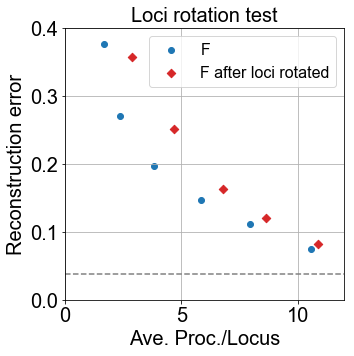

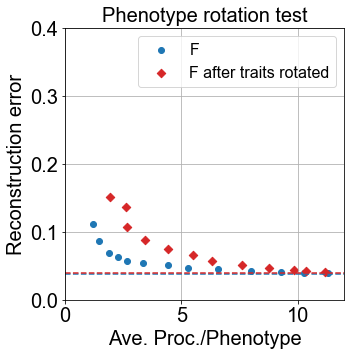

In [29]:
#Display results of rotation test
yrange = (0,.4)
xrange = (0,12)
figsize = (3,5)

rotate = "loci"
plot_rotation_test(fct, fct_fo, Kmax, lambW, lambM_range, xrange, yrange, rotate, fs = 20, svd_k=Kmax, true_line = False)

rotate = "env"
plot_rotation_test(fct, fct_of, Kmax, lambW_range, lambM, xrange, yrange, rotate, fs = 20, svd_k=Kmax, true_line = False)

### Visualize a solution 

W: plot



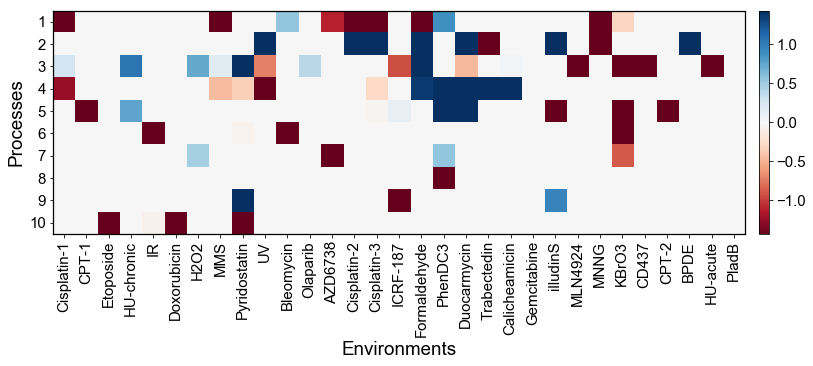

M: plot



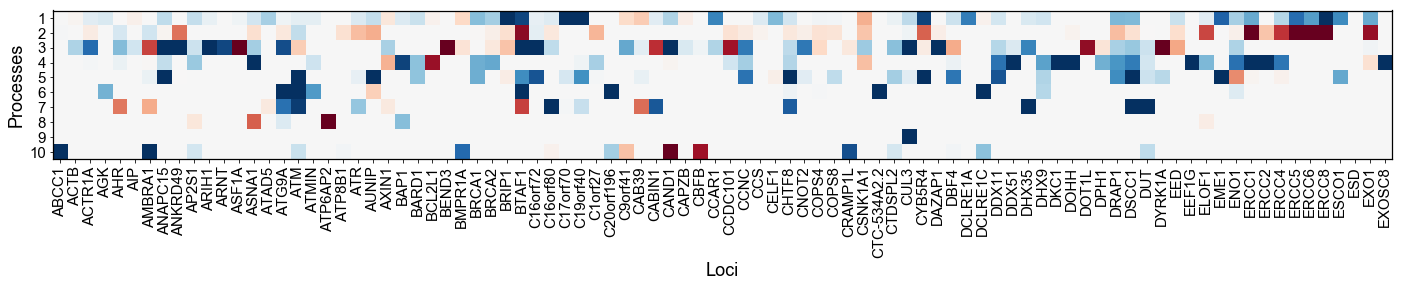

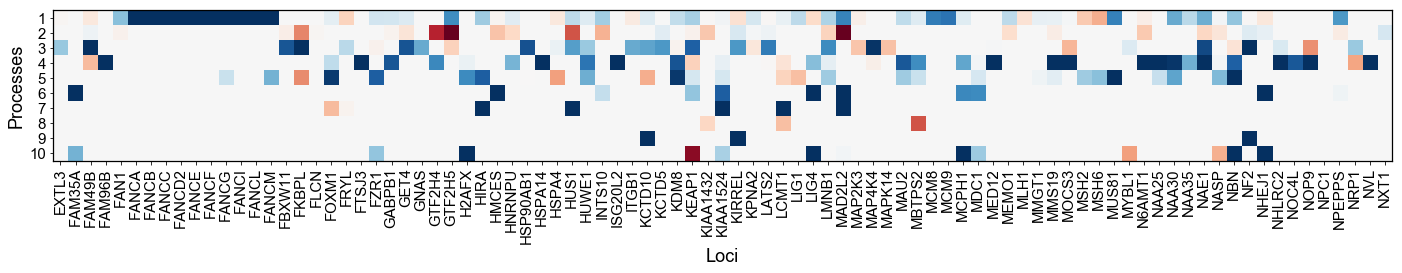

In [33]:
p = find_key(fct,3.2,2.5) #convert the pair avg. proc. per loci and avg. proc. per. phen to the appropriate key
plot_Ws(fct, p, labelsize = 15, pp = 95) #pp picks the colorbar range

plot_Ms(fct, p, labelsize = 15, pp = 95)